# HRS Spectrometer Neural Network Model

In [1]:
import  pandas as pd
import numpy as np
import sklearn
import math
import matplotlib
%matplotlib inline

## Prepare the data
### 1). Load the files

In [2]:
files = ["./data/PRex_DataSet_2239.csv",
         "./data/PRex_DataSet_2240.csv",
         "./data/PRex_DataSet_2241.csv",
         "./data/PRex_DataSet_2244.csv",
         "./data/PRex_DataSet_2245.csv",
         "./data/PRex_DataSet_2256.csv",
         "./data/PRex_DataSet_2257.csv"
         ]

li = []

for filename in files:
    print("Loading the file {}...".format(filename))
    df = pd.read_csv(filename)
    li.append(df)
data = pd.concat(li)
data.sample(frac=1) # sample the data with fraction 1. rearrange the data in random order
data.head()

Loading the file ./data/PRex_DataSet_2239.csv...
Loading the file ./data/PRex_DataSet_2240.csv...
Loading the file ./data/PRex_DataSet_2241.csv...
Loading the file ./data/PRex_DataSet_2244.csv...
Loading the file ./data/PRex_DataSet_2245.csv...
Loading the file ./data/PRex_DataSet_2256.csv...
Loading the file ./data/PRex_DataSet_2257.csv...


,evtID,runID,CutID,SieveRowID,SieveColID,bpmX,bpmY,focal_x,focal_y,focal_th,focal_ph,targCalTh,targCalPh
0,0,2239,136,3,5,0.003794,-0.000501,-0.014535,0.011066,0.000552,-0.001618,-0.000817,-0.010117
1,1,2239,130,4,4,0.003794,-0.000501,-0.027425,0.008514,-0.006709,-0.009000,0.019571,-0.012569
2,2,2239,179,4,11,0.003794,-0.000501,-0.013932,-0.014659,-0.006437,0.014969,0.012775,0.014835
3,3,2239,142,2,6,0.003794,-0.000501,-0.010740,0.003021,0.005594,0.001385,-0.014409,-0.003863
4,4,2239,127,1,4,0.003794,-0.000501,-0.002179,0.012108,0.006449,-0.004135,-0.021206,-0.012569


### 2). Check the Theoretical Value of $\theta$ and $\phi$ on targe

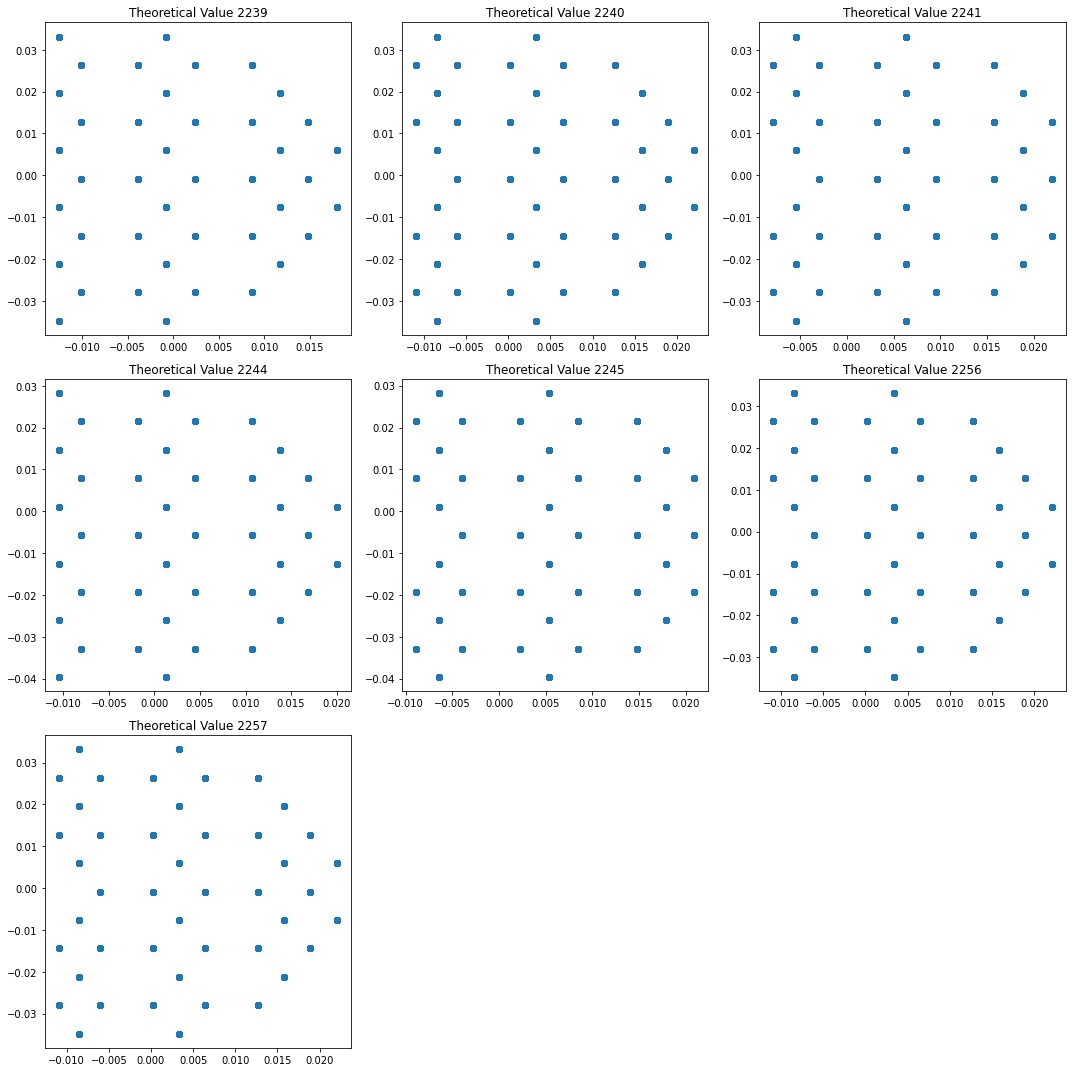

In [3]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=[15,15])
gs = gridspec.GridSpec(nrows=3, ncols=3, height_ratios=[1, 1, 1])

ax0 = fig.add_subplot(gs[0, 0])
ax0.scatter(data[data.runID.eq(2239)]["targCalPh"],data[data.runID.eq(2239)]["targCalTh"])
ax0.set_title('Theoretical Value 2239')

ax1 = fig.add_subplot(gs[0, 1])
ax1.scatter(data[data.runID.eq(2240)]["targCalPh"],data[data.runID.eq(2240)]["targCalTh"])
ax1.set_title('Theoretical Value 2240')

ax2 = fig.add_subplot(gs[0, 2])
ax2.scatter(data[data.runID.eq(2241)]["targCalPh"],data[data.runID.eq(2241)]["targCalTh"])
ax2.set_title('Theoretical Value 2241')

ax3 = fig.add_subplot(gs[1, 0])
ax3.scatter(data[data.runID.eq(2244)]["targCalPh"],data[data.runID.eq(2244)]["targCalTh"])
ax3.set_title('Theoretical Value 2244')

ax4 = fig.add_subplot(gs[1, 1])
ax4.scatter(data[data.runID.eq(2245)]["targCalPh"],data[data.runID.eq(2245)]["targCalTh"])
ax4.set_title('Theoretical Value 2245')

ax5 = fig.add_subplot(gs[1, 2])
ax5.scatter(data[data.runID.eq(2256)]["targCalPh"],data[data.runID.eq(2256)]["targCalTh"])
ax5.set_title('Theoretical Value 2256')

ax6 = fig.add_subplot(gs[2, 0])
ax6.scatter(data[data.runID.eq(2257)]["targCalPh"],data[data.runID.eq(2257)]["targCalTh"])
ax6.set_title('Theoretical Value 2257')

plt.tight_layout()
plt.show()

### 3). Pre-process the data

In [4]:
from sklearn.model_selection import train_test_split
from torch.utils.data import  Dataset, TensorDataset, DataLoader
import torch


train_X, test_X, train_y, test_y = train_test_split(
    data.drop(labels=['evtID','runID','SieveRowID','SieveColID','CutID','bpmX','bpmY','targCalTh','targCalPh'], axis=1),
    data[['targCalTh','targCalPh']],
    test_size=0.2,
    random_state=0)

batchSize = 1

train_X_tensor = torch.tensor(train_X.to_numpy()).float()
train_yTh_tensor = torch.tensor(train_y['targCalTh'].to_numpy()).float()
train_yPh_tensor = torch.tensor(train_y['targCalPh'].to_numpy()).float()

test_X_tensor  = torch.tensor(test_X.to_numpy()).float()
test_yTh_tensor  = torch.tensor(test_y['targCalTh'].to_numpy()).float()
test_yPh_tensor  = torch.tensor(test_y['targCalPh'].to_numpy()).float()

train_theta_loader = DataLoader(dataset=TensorDataset(train_X_tensor,train_yTh_tensor),batch_size=batchSize)
train_phi_loader   = DataLoader(dataset=TensorDataset(train_X_tensor,train_yPh_tensor),batch_size=batchSize)

test_theta_loader = DataLoader(dataset=TensorDataset(test_X_tensor,test_yTh_tensor),batch_size=batchSize)
test_phi_loader   = DataLoader(dataset=TensorDataset(test_X_tensor,test_yPh_tensor),batch_size=batchSize)

## Build the model and Get the GPUs

In [5]:
import torch.nn as nn
import torch.nn.functional as F

def build_net(startNode = 4, maxNode=16, maxRepeat=6,NodeDropRate=4,endNode = 1):
    Layers =[]
    LastNode = startNode
    currentNode = startNode
    while currentNode <= maxNode:
        # Layers.append([LastNode,currentNode])
        Layers.append(nn.modules.Linear(LastNode,currentNode))
        Layers.append(nn.modules.Sigmoid())
        for _ in range(maxRepeat):
            # Layers.append([currentNode,currentNode])
            Layers.append(nn.modules.Linear(currentNode,currentNode))
            Layers.append(nn.modules.Sigmoid())

        LastNode = currentNode
        currentNode = currentNode*NodeDropRate
        if currentNode > maxNode:
            currentNode = currentNode//NodeDropRate
            break
    while currentNode > endNode:
        currentNode = currentNode//NodeDropRate
        Layers.append(nn.modules.Linear(LastNode,currentNode))
        Layers.append(nn.modules.Sigmoid())

        # Layers.append([LastNode,currentNode])
        for _ in range(maxRepeat):
            Layers.append(nn.modules.Linear(currentNode,currentNode))
            Layers.append(nn.modules.Sigmoid())
            # Layers.append([currentNode,currentNode])
        LastNode = currentNode

    Layers.append(nn.modules.Linear(currentNode,currentNode))

    return Layers

from IPython.core.display import display, HTML
display(HTML('<h2>Default Total Layer {}</h2>'.format(len(build_net())//2)))

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Train the model With All GPUs
### 1. Train the $\theta_{targ}$ dimension

In [7]:
import torch.optim as optim
thetaOptnet = nn.Sequential(*build_net())
thetaOptnet.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(thetaOptnet.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
for epoch in range(100):
    running_loss = 0.0
    for i, data in enumerate(train_theta_loader):
        inputs, labels = data
        # print(inputs)
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = thetaOptnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d, %6f] loss: %.9f' %
                  (epoch + 1, i + 1, optimizer.param_groups[0]['lr'],running_loss / 200))
            running_loss = 0.0
    torch.save(thetaOptnet.state_dict(), "./model/Theta_net_ep{}.pth".format(epoch))
    scheduler.step()

print("Finish Training Theta Parameters")
# save the training model
theta_model_PATH = './model/Theta_net.pth'
torch.save(thetaOptnet.state_dict(), theta_model_PATH)

/home/newdriver/Storage/HomeDir/Learning/spectrometer_nn/venv/lib/python3.9/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[1,   200, 0.010000] loss: 0.063371040
[1,   400, 0.010000] loss: 0.000345463
[1,   600, 0.010000] loss: 0.000421459
[1,   800, 0.010000] loss: 0.000402794
[1,  1000, 0.010000] loss: 0.000359194
[1,  1200, 0.010000] loss: 0.000376992
[1,  1400, 0.010000] loss: 0.000447341
[1,  1600, 0.010000] loss: 0.000436900
[1,  1800, 0.010000] loss: 0.000398659
[1,  2000, 0.010000] loss: 0.000412482
[1,  2200, 0.010000] loss: 0.000448166
[1,  2400, 0.010000] loss: 0.000457179
[1,  2600, 0.010000] loss: 0.000454177
[1,  2800, 0.010000] loss: 0.000461210
[1,  3000, 0.010000] loss: 0.000498984
[1,  3200, 0.010000] loss: 0.000435775
[1,  3400, 0.010000] loss: 0.000421482
[1,  3600, 0.010000] loss: 0.000522570
[1,  3800, 0.010000] loss: 0.000517138
[1,  4000, 0.010000] loss: 0.000431429
[1,  4200, 0.010000] loss: 0.000465388
[1,  4400, 0.010000] loss: 0.000508599
[1,  4600, 0.010000] loss: 0.000464756
[1,  4800, 0.010000] loss: 0.000472855
[1,  5000, 0.010000] loss: 0.000527627
[1,  5200, 0.010000] loss

KeyboardInterrupt: 

### 2. Train the $\phi_{targ}$ dimension

In [ ]:
import torch.optim as optim
phiOptnet = nn.Sequential(*build_net())
phiOptnet.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(phiOptnet.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
for epoch in range(100):
    running_loss = 0.0
    for i, data in enumerate(train_phi_loader):
        inputs, labels = data
        # print(inputs)
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = phiOptnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d, %6f] loss: %.9f' %
                  (epoch + 1, i + 1, optimizer.param_groups[0]['lr'],running_loss / 200))
            running_loss = 0.0
    torch.save(thetaOptnet.state_dict(), "./model/Phi_net_ep{}.pth".format(epoch))
    scheduler.step()

print("Finish Training Theta Parameters")
# save the training model
theta_model_PATH = './model/Phi_net.pth'
torch.save(thetaOptnet.state_dict(), theta_model_PATH)

## Draw the plot
